In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp plot

# Plot

> Functions to help plot sequential forecasts and coefficients created during an analysis.

In [ ]:
#hide
#exporti
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
#export
def ax_style(ax, ylim=None, xlim=None, xlabel=None, ylabel=None, title=None,
             legend=None, legend_inside_plot=True, topborder=False, rightborder=False, **kwargs):
    """
    A helper function to define many elements of axis style at once.
    """

    if legend is not None:
        if legend_inside_plot:
            ax.legend(legend)
        else:
            ax.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, frameon=False)
            # Make room for the legend
            plt.subplots_adjust(right=.85)

    if ylim is not None: ax.set_ylim(ylim)
    if xlim is not None: ax.set_xlim(xlim)
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title is not None: ax.set_title(title)

    # remove the top and right borders
    ax.spines['top'].set_visible(topborder)
    ax.spines['right'].set_visible(rightborder)

    plt.tight_layout()

    return ax

In [ ]:
#export
# Plot Data vs Forecast (with credible intervals)
def plot_data_forecast(fig, ax, y, f, samples, dates, linewidth=1, linecolor='b', credible_interval=95, **kwargs):
    """
    Plot observations along with sequential forecasts and credible intervals.
    """

    ax.scatter(dates, y, color='k')
    ax.plot(dates, f, color=linecolor, linewidth=linewidth)
    alpha = (100 - credible_interval) / 2
    upper = np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower = np.percentile(samples, [alpha], axis=0).reshape(-1)
    ax.fill_between(dates, upper, lower, alpha=.3, color=linecolor)

    if kwargs.get('xlim') is None:
        kwargs.update({'xlim':[dates[0], dates[-1]]})
        
    if kwargs.get('legend') is None:
        legend = ['Forecast', 'Observations', 'Credible Interval']
        
    ax = ax_style(ax, legend=legend, **kwargs)

    # If dates are actually dates, then format the dates on the x-axis
    if isinstance(dates[0], (datetime, date)):
        fig.autofmt_xdate()

    return ax

The most commonly used plotting function, `plot_data_forecast` enables the plotting of sequential forecasts following an analysis. `ax_style` is a useful wrapper around some of the most common `matplotlib.pyplot` axis functionality.

A simple demonstration is given below. We start by running an analysis of simulated retail sales data:

In [ ]:
from pybats.shared import load_sales_example2
from pybats.analysis import analysis
from pybats.plot import plot_data_forecast
from pybats.point_forecast import median
from pybats.loss_functions import MAPE

import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar


data = load_sales_example2()

prior_length = 21   # Number of days of data used to set prior
k = 14               # Forecast horizon
rho = 0.6           # Random effect discount factor to increase variance of forecast distribution
forecast_samps = 2000  # Number of forecast samples to draw
forecast_start = pd.to_datetime('2018-01-01') # Date to start forecasting
forecast_end = pd.to_datetime('2018-03-01')   # Date to stop forecasting

mod, samples, model_coef = analysis(data.Sales.values, data[['Price', 'Promotion']].values,
                        k, forecast_start, forecast_end, nsamps=2000,
                        family='poisson',
                        seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                        prior_length=prior_length, dates=data.index, holidays=USFederalHolidayCalendar.rules,
                        rho=rho,
                        ret = ['model', 'forecast', 'model_coef'])

beginning forecasting


Next, we will plot the forecasts, both $1-$ and $14-$days ahead.

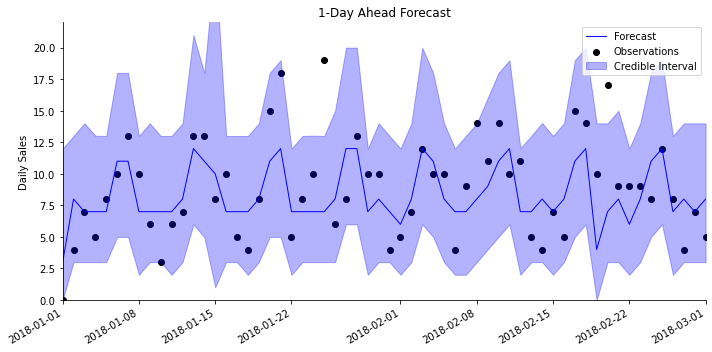

In [ ]:
forecast = median(samples)

# Plot the 1-day ahead forecast
h = 1
start = forecast_start + pd.DateOffset(h - 1)
end = forecast_end + pd.DateOffset(h - 1)

data_1step = data.loc[start:end]
samples_1step = samples[:,:,h-1]
fig, ax = plt.subplots(figsize=(10,5))
plot_data_forecast(fig, ax,
                   data_1step.Sales,
                   median(samples_1step),
                   samples_1step,
                   data_1step.index,
                   credible_interval=95)

ax_style(ax, title='1-Day Ahead Forecast', ylabel='Daily Sales', ylim=[0,22])

pass

The $1-$day ahead forecasts are generally quite accurate! It appears that most points are falling within the $95\%$ credible intervals. There is also a clear weekly pattern to the sales that the model has detected.

Let's take a look at the $14-$day ahead forecasts:

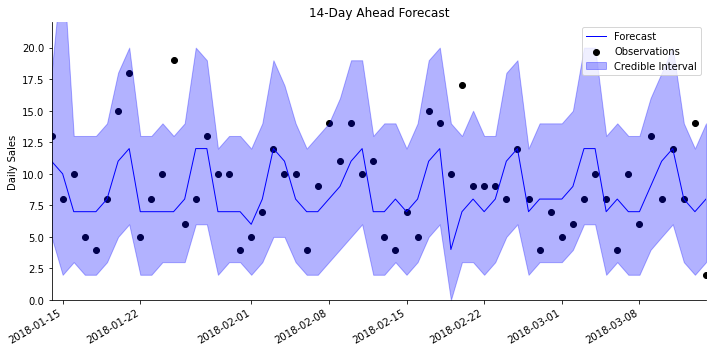

In [ ]:
# Plot the 14-day ahead forecast
h = 14
start = forecast_start + pd.DateOffset(h - 1)
end = forecast_end + pd.DateOffset(h - 1)

data_14step = data.loc[start:end]
samples_14step = samples[:,:,h-1]
fig, ax = plt.subplots(figsize=(10,5))
plot_data_forecast(fig, ax,
                   data_14step.Sales,
                   median(samples_14step),
                   samples_14step,
                   data_14step.index,
                   credible_interval=95)

ax_style(ax, title='14-Day Ahead Forecast', ylabel='Daily Sales', ylim=[0,22])

pass

These longer term forecasts are nearly as accurate as the $1-$day ahead forecasts. Note that the dates here start at January 13th, 14 days after the forecasting window began on January 1st.

In [ ]:
#export

def plot_coef(fig, ax, coef, dates, linewidth=1, linecolor=None, legend_inside_plot=True, coef_samples=None, **kwargs):
    """
    Plot coefficients over time.
    """

    if linecolor is not None:
        ax.plot(dates, coef, linewidth=linewidth, color=linecolor)
    else:
        ax.plot(dates, coef, linewidth=linewidth)

    # If dates are actually dates, then format the dates on the x-axis
    if isinstance(dates[0], (datetime, date)):
        fig.autofmt_xdate()

    ax = ax_style(ax, legend_inside_plot=legend_inside_plot, **kwargs)

    # Add credible intervals if samples are provided
    if coef_samples is not None:
        upper = np.percentile(coef_samples, [97.5], axis=0).reshape(-1)
        lower = np.percentile(coef_samples, [2.5], axis=0).reshape(-1)
        ax.fill_between(dates, upper, lower, alpha=.3, color=linecolor)


    # Include the y-axis labels on all subplots, which is not the matplotlib default
    ax.tick_params(labelleft=True)

    return ax

This function is useful for plotting model coefficients over time. There is a detailed explanation of plotting the day-of-week seasonality coefficients in the [sales forecasting example](https://github.com/lavinei/pybats_nbdev/blob/master/examples/Poisson_DGLM_In_Depth_Example.ipynb).

For this example, let's focus on any trends in the baseline level of sales. To track this, we will plot the intercept, which is the first coefficient in the trend term. The model coefficients have already been saved from the analysis we ran above.

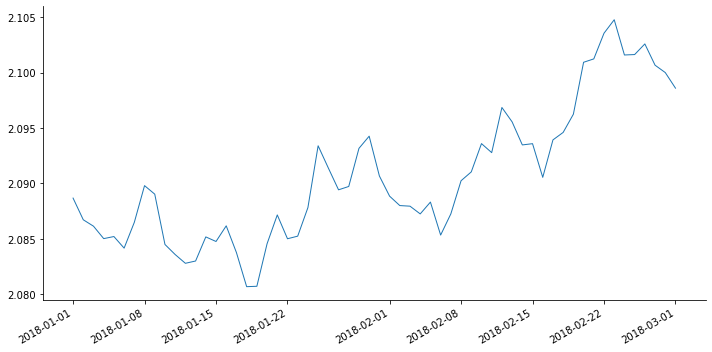

In [ ]:
# Plot the mean of the intercept through the forecasting time window
plot_data = pd.DataFrame({'Intercept_Mean':model_coef['m'][:, mod.itrend[0]]}, index=data.index)
plot_data = plot_data.loc[forecast_start:forecast_end]

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_coef(fig, ax, plot_data.Intercept_Mean, plot_data.index);

It appears that the baseline level of sales are climbing throughout the forecast period!

In [ ]:
#export
def plot_corr(fig, ax, corr, labels=None):
    """
    Plot a correlation matrix with a heatmap.
    """

    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                       cmap=sns.diverging_palette(10, 240, as_cmap=True),
                       cbar=True,
                       square=True, ax=ax,
                       xticklabels=labels,
                       yticklabels=labels)
    ax.set_xticklabels(labels=labels, rotation=45, size=9)
    ax.set_yticklabels(labels=labels, rotation=0, size=9)
    return ax

This function is convenient for plotting a correlation matrix. It is commonly used to plot the correlations among model coefficients. It's a wrapper around the seaborn function `sns.heatmap`, with the colors scaled appropriately to highlight correlations.

To demonstrate, we'll plot the correlations among the trend and regression coefficients in the model from the examples above.

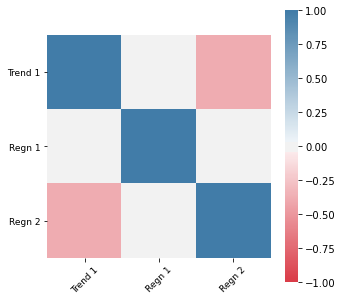

In [ ]:
p = mod.ntrend + mod.nregn_exhol

cov = mod.R[:p,:p]
D = np.sqrt(cov.diagonal()).reshape(-1,1)
corr = cov/D/D.T

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(fig, ax, corr = corr, labels=['Trend 1', 'Regn 1', 'Regn 2']);

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_dglm.ipynb.
Converted 01_update.ipynb.
Converted 02_forecast.ipynb.
Converted 03_define_models.ipynb.
Converted 04_seasonal.ipynb.
Converted 05_analysis.ipynb.
Converted 06_conjugates.ipynb.
Converted 07_point_forecast.ipynb.
Converted 08_loss_functions.ipynb.
Converted 09_plot.ipynb.
Converted 10_shared.ipynb.
Converted 11_dcmm.ipynb.
Converted 12_dbcm.ipynb.
Converted 13_latent_factor.ipynb.
Converted 14_latent_factor_fxns.ipynb.
Converted index.ipynb.
